# TMDB 电影数据分析

本文中用到的数据文件：tmdb_5000_movies.csv、tmdb_5000_credits.csv是Kaggle平台上的项目TMDB(The Movie Database)，共计4803部电影，主要为美国地区一百年间（1916-2017）的电影作品。

本文通过对电影数据的分析，利用数据可视化的方法，发现流行趋势，找到投资方向，为本行业新入局者提供一定参考建议。同时也为了提升自己的数据分析能力，在遇到类似项目可以触类旁通。

**主要包括一下几个部分**:
- 数据预处理
- 特征提取
- 特征选取
- 数据可视化

In [1]:
import os
import numpy as np
import pandas as pd
import json
from wordcloud import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline

## 1- 问题陈述

官网的问题描述地址（https://www.kaggle.com/tmdb/tmdb-movie-metadata/home).

从电影市场趋势，受众喜好，电影票房等三个方面主要研究以下几个问题：

- 各类型电影数量分布及随时间变化趋势如何？
- 不同类型电影的盈利能力如何？
- 原创电影与改编电影有何差异？
- 电影大多产自什么地方？
- 电影关键字分析
- 受众喜好与那些因素有关？
- Universal Pictures与Paramount Pictures两家行业巨头的业绩如何？
- 电影票房与哪些因素最相关？


## 2-查看数据

从Kaggle平台上下载2个原始数据集：tmdb_5000_movies.csv和tmdb_5000_credits.csv，movies存放电影的基本信息，credits存放电影的演职员名单。相关字段含义介绍：

| 字段 | 含义 | 
| ------| ------ | 
| title | 电影名称 |
| cast | 演员列表 |
| director | 导演 |
| budget | 预算（美元） |
| genres | 电影类型 |
| homepage | 电影首页的 URL |
| id | 标识号 |
| original_language | 电影语言 |
| original_title | 电影名称 |
| overview | 剧情摘要 |
| popularity | 在 Movie Database 上的相对页面查看次数 |
| production_companies | 制作公司 |
| production_countries | 制作国家 |
| release_date | 上映时间 |
| revenue | 票房收入 |
| runtime | 电影时长 |
| spoken_languages | 口语 |
| tagline | 电影的标语 |
| vote_average | 平均评分 |
| vote_count | 评分次数 |

In [2]:
# 加载数据
credits = pd.read_csv('data/tmdb_5000_credits.csv')
movies = pd.read_csv('data/tmdb_5000_movies.csv')
#credits.head()
#movies.head()

# credits 和 movies 中都有title 字段，删除其中一个
del credits['title']
# 做链接方式合并数据
total = pd.merge(movies,credits,left_on='id', right_on='movie_id', how='left')
# 不需要字段
drop_title=['homepage','id','original_language','original_title','overview','spoken_languages','status','tagline','movie_id','cast','crew']
total.drop(drop_title,axis=1,inplace=True)

我们看一下合并完之后的数据信息，先查看一下shape和第一行信息：

In [3]:
print(total.shape)
# 查看第一行信息
print(total.iloc[0])

(4803, 12)
budget                                                          237000000
genres                  [{"id": 28, "name": "Action"}, {"id": 12, "nam...
keywords                [{"id": 1463, "name": "culture clash"}, {"id":...
popularity                                                        150.438
production_companies    [{"name": "Ingenious Film Partners", "id": 289...
production_countries    [{"iso_3166_1": "US", "name": "United States o...
release_date                                                   2009-12-10
revenue                                                        2787965087
runtime                                                               162
title                                                              Avatar
vote_average                                                          7.2
vote_count                                                          11800
Name: 0, dtype: object


release_date列有1条缺失数据，将其查找出来并填充：

In [4]:
total[total.release_date.isnull()]

,budget,genres,keywords,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
4553,0,[],[],0.0,[],[],NaN,0,0.0,America Is Still the Place,0.0,0


In [5]:
total.release_date = total.release_date.fillna('2014-06-01')

runtime列有2条缺失数据，将其查找出来并填充：

In [6]:
total[total.runtime.isnull()]

,budget,genres,keywords,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
2656,15000000,"[{""id"": 18, ""name"": ""Drama""}]","[{""id"": 717, ""name"": ""pope""}, {""id"": 5565, ""na...",0.738646,"[{""name"": ""Taodue Film"", ""id"": 45724}]","[{""iso_3166_1"": ""IT"", ""name"": ""Italy""}]",2015-12-03,0,NaN,Chiamatemi Francesco - Il Papa della gente,7.3,12
4140,2,"[{""id"": 99, ""name"": ""Documentary""}]","[{""id"": 6027, ""name"": ""music""}, {""id"": 225822,...",0.050625,"[{""name"": ""Eyeline Entertainment"", ""id"": 60343}]","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""}]",2015-12-12,0,NaN,"To Be Frank, Sinatra at 100",0.0,0


In [7]:
total.runtime=total.runtime.fillna(94,limit=1)
total.runtime=total.runtime.fillna(240,limit=1)

对于release_date列，需将其转换为日期类型并提取出年份，并查看处理结果:

In [8]:
total.release_date=pd.to_datetime(total.release_date,format='%Y-%m-%d',errors='coerce').dt.year
total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 12 columns):
budget                  4803 non-null int64
genres                  4803 non-null object
keywords                4803 non-null object
popularity              4803 non-null float64
production_companies    4803 non-null object
production_countries    4803 non-null object
release_date            4803 non-null int64
revenue                 4803 non-null int64
runtime                 4803 non-null float64
title                   4803 non-null object
vote_average            4803 non-null float64
vote_count              4803 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 487.8+ KB


## 2-特殊格式数据处理

本项目要进行研究的数据中的genres，keywords，production_companies，production_countries列均为json格式，不便对其进行分析。需先导入json（开始已操作），再通过json.loads先将json字符串转换为字典列表形式，再使用循环，选取需要的数据，本次分析取出name键所对应的值，并用“|”分隔。


In [9]:
json_column = ['genres','keywords','production_companies','production_countries']
for column in json_column:
    total[column] = total[column].map(json.loads)
def getName(x):
    name = []
    for item in x:
        name.append(item['name'])
    return '|'.join(name)
for column in json_column:
    total[column] = total[column].map(getName)

In [10]:
total.head(2)

,budget,genres,keywords,popularity,production_companies,production_countries,release_date,revenue,runtime,title,vote_average,vote_count
0,237000000,Action|Adventure|Fantasy|Science Fiction,culture clash|future|space war|space colony|so...,150.437577,Ingenious Film Partners|Twentieth Century Fox ...,United States of America|United Kingdom,2009,2787965087,162.0,Avatar,7.2,11800
1,300000000,Adventure|Fantasy|Action,ocean|drug abuse|exotic island|east india trad...,139.082615,Walt Disney Pictures|Jerry Bruckheimer Films|S...,United States of America,2007,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500


## 3-数据分析和可视化

### 3-1-各电影类型数量分布及随时间变化趋势如何

先找到所有电影类型，并存放到genre_set集合中：

In [11]:
genre_set = set()
for item in total['genres']:
    genre_set.update(item.split('|'))
genre_set.discard('')
print("genres num: %d" % len(genre_set))

genres num: 20


构造电影类型和年份的数据框：

In [12]:
genre_df = pd.DataFrame()
for genre in genre_set:
    genre_df[genre] = total['genres'].str.contains(genre).map(lambda x: 1 if x else 0)
genre_df['release_date']=total['release_date']
genre_by_year = genre_df.groupby('release_date').sum()
genre_by_year.tail(2)


,War,Mystery,Foreign,Drama,Documentary,Crime,Comedy,Science Fiction,TV Movie,Animation,Music,Horror,Western,Family,History,Adventure,Romance,Action,Fantasy,Thriller
release_date,,,,,,,,,,,,,,,,,,,,
2016,3,6,0,37,0,10,26,11,0,4,1,20,1,9,6,23,9,39,13,27
2017,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


绘图显示

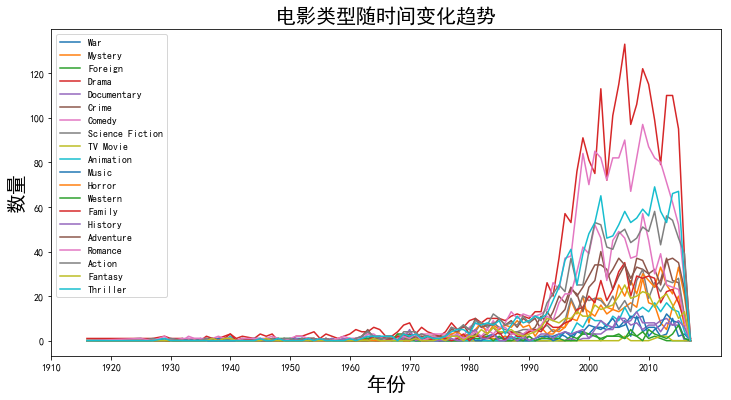

In [18]:
def show_genre_year(genre_by_year):
    plt.rcParams['font.sans-serif']=['SimHei']
    fig = plt.figure(figsize=(12,6))
    plt.plot(genre_by_year)
    plt.legend(genre_by_year)
    plt.title("电影类型随时间变化趋势",fontsize=20)
    plt.xticks(range(1910,2018,10))
    plt.xlabel("年份",fontsize=20)
    plt.ylabel("数量",fontsize=20)
    plt.show()
show_genre_year(genre_by_year)

各电影类型数量和：

In [14]:
genre_sum = genre_by_year.sum(axis=0).sort_values(ascending=True)
genre_sum

TV Movie              8
Foreign              34
Western              82
Documentary         110
War                 144
Music               185
History             197
Animation           234
Mystery             348
Fantasy             424
Family              513
Horror              519
Science Fiction     535
Crime               696
Adventure           790
Romance             894
Action             1154
Thriller           1274
Comedy             1722
Drama              2297
dtype: int64

绘图显示各类电影数量的对比：

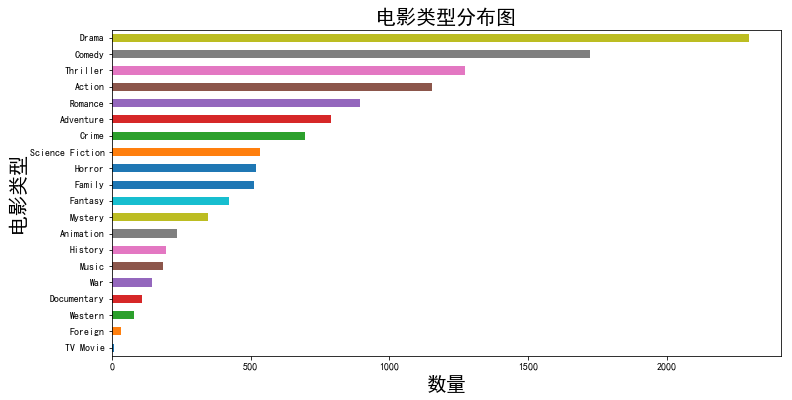

In [15]:
def show_gen_um(genre_sum):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    genre_sum.plot.barh(label='genre',figsize=(12,6))
    plt.title("电影类型分布图",fontsize=20)
    plt.xlabel("数量",fontsize=20)
    plt.ylabel("电影类型",fontsize=20)
    plt.show()
show_gen_um(genre_sum)

由图可知，数量前5的电影类型为：戏剧类（Drama）、喜剧类（Comedy）、惊悚类（Thriller）、动作类（Action）、冒险类（Adventure）

### 3-2-不同类型电影的盈利能力如何

In [23]:
def get_genre_profit(total):
    profit_df = pd.DataFrame()
    total['profit'] = total['revenue'] - total['budget']
    profit_df = pd.concat([genre_df.iloc[:, :-1], total['profit']], axis=1)
    profit_by_genre = pd.Series(index=genre_set)
    for genre in genre_set:
        # 每次循环按照一个类型进行划分，分成是这一类型和不是这一类型两种，然后分别计算这两类的平均值，然后取是这一类的均值
        # 注意 loc[1],指的是索引为1的那一行，而不是行号
        profit_by_genre[genre] = profit_df.groupby(genre)['profit'].mean().loc[1]
    profit_by_genre = profit_by_genre.sort_values(ascending=False)

    print(profit_by_genre)

    return profit_by_genre

In [24]:
def show_genre_profit(profit_by_genre):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    profit_by_genre.plot.barh(label='genre', figsize=(12, 6))
    plt.title('电影类型利润分布图', fontsize=20)
    plt.xlabel('利润', fontsize=20)
    plt.ylabel('电影类型', fontsize=20)
    plt.show()

Animation          1.592271e+08
Adventure          1.423333e+08
Fantasy            1.297936e+08
Family             1.116260e+08
Science Fiction    1.005910e+08
Action             8.970235e+07
Thriller           4.907608e+07
War                4.887342e+07
Mystery            4.755644e+07
Comedy             4.597608e+07
Romance            3.969103e+07
Crime              3.830085e+07
Music              3.254800e+07
Drama              3.143791e+07
Horror             2.897105e+07
History            2.762010e+07
Western            1.916726e+07
Documentary        7.185600e+06
Foreign           -2.934369e+05
TV Movie          -1.150000e+06
dtype: float64


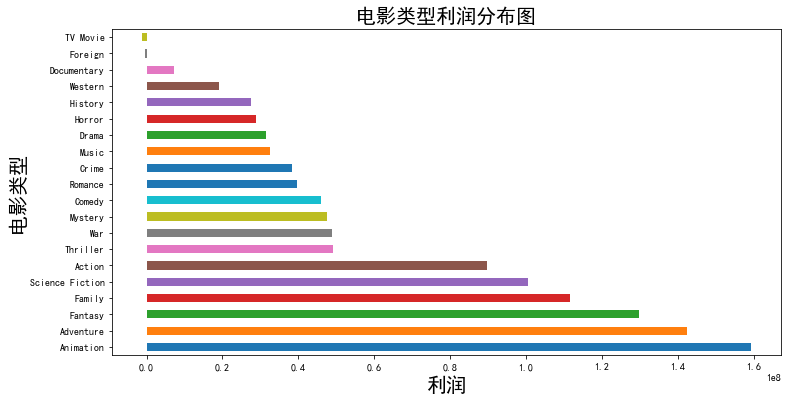

In [25]:
profit_by_genre = get_genre_profit(total)
show_genre_profit(profit_by_genre)

由图可知，平均收益前3的电影类型为：动画类（Animation）、冒险类（Adventure）、科幻类（Fantasy），而外国电影类（Foreign）和电视电影类（TV Movie）有亏损的风险。

### 3-3-原创电影与改编电影有何差异

电影数量对比

建立original-recompose的DataFrame，放入budget，profit，count（数量）等字段，并计算利润率profit_rate=(profit-budget)/budget*100%

In [27]:
def get_original_recompose(total):
    original_recompose = pd.DataFrame()
    original_recompose['type'] = total['keywords'].str.contains('based on novel').map(lambda x: 1 if x else 0)
    count_list = original_recompose.groupby('type')['type'].count()
    original_recompose['profit'] = total['profit']
    original_recompose['budget'] = total['budget']
    print(original_recompose.info())
    original_recompose = original_recompose.groupby('type').mean()
    original_recompose['count'] = count_list
    original_recompose['profit_rate'] = original_recompose['profit'] / original_recompose['budget']
    original_recompose.rename(index={0: 'original', 1: 'recompose'}, inplace=True)
    print(original_recompose)
    return original_recompose

In [28]:
def show_ori_recom1(original_recomposee):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    fig = plt.figure(figsize=(12, 6))
    data_count = original_recomposee.loc[original_recomposee.index, 'count']
    plt.bar(original_recomposee.index, data_count)
    plt.xlabel("原创-改编")
    plt.ylabel("数量")
    plt.show()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4803 entries, 0 to 4802
Data columns (total 3 columns):
type      4803 non-null int64
profit    4803 non-null int64
budget    4803 non-null int64
dtypes: int64(3)
memory usage: 150.1 KB
None
                 profit        budget  count  profit_rate
type                                                     
original   5.127943e+07  2.834872e+07   4606     1.808880
recompose  9.848457e+07  4.532546e+07    197     2.172831


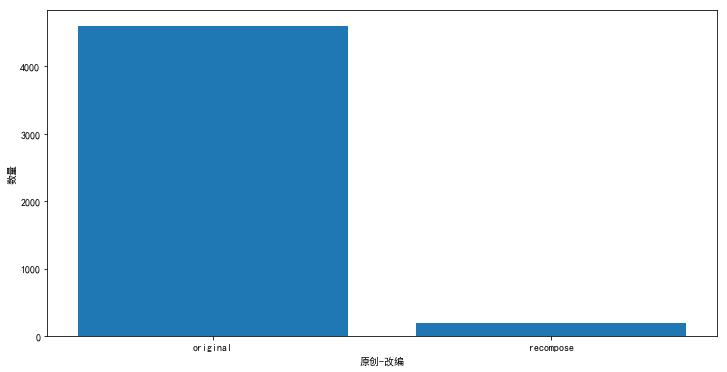

In [31]:
original_recomposee = get_original_recompose(total)
show_ori_recom1(original_recomposee)

利润及利润率对比

In [34]:
def show_ori_recom2(original_recomposee):
    # 绘制利润柱状图
    plt.rcParams['font.sans-serif'] = ['SimHei']
    x = list(range(len(original_recomposee.index)))
    index = original_recomposee.index
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.bar(index, original_recomposee['profit'])
    ax1.set_title('原创与改编的利润对比')
    ax1.set_ylabel('利润')
    ax1.set_xlabel('原创-改编')
    # 绘制利润率折线图
    import matplotlib.ticker as mtick
    ax2 = ax1.twinx()
    ax2.plot(index, original_recomposee['profit_rate'], 'ro-', lw=2)
    fmt = '%.2f%%'
    yticks = mtick.FormatStrFormatter(fmt)
    ax2.yaxis.set_major_formatter(yticks)
    ax2.set_ylabel('利润率')
    plt.show()

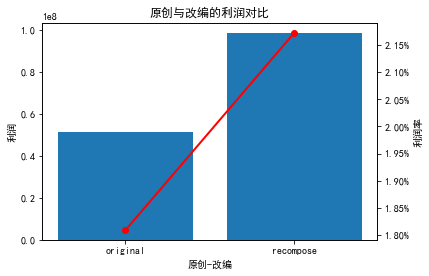

In [35]:
show_ori_recom2(original_recomposee)

依据利润和利润率数据来看，改编电影无论是利润还是利润率都远高于原创电影，看来改编电影吸引了更多受众观看，带来了更高利润。大概是改编电影的原著剧本早在电影上映前就已经经过了市场的检验，对准了受众的喜好，在此基础上改编的电影也吸引了不少原著粉丝。因此电影制作公司若遇上市场反响不错的小说漫画等，将其改编为电影，成功的概率更高。

### 3-4-电影大多产自什么地方

In [36]:
def get_country_count(total):
    country_set = set()
    for x in total['production_countries']:
        country_set.update(x.split('|'))
    country_set.discard('')
    country_df = pd.DataFrame()
    for country in country_set:
        country_df[country] = total['production_countries'].str.contains(country).map(lambda x: 1 if x else 0)
    # 数据类型是Series
    country_df = country_df.sum().sort_values(ascending=False)
    return country_df

In [37]:
def show_country_count(country_df):
    rate = country_df / country_df.sum()
    others = 0.01
    # 只留下比例大于0.01的国家
    rate1 = rate[rate >= others]
    # 占比小于0.01的 都归于 其它
    rate1['others'] = rate[rate < others].sum()
    # 占比大于4%的向外延伸
    explode = (rate1 >= 0.04) / 20 + 0.02
    rate1.plot.pie(autopct='%1.1f%%', figsize=(10, 10), explode=explode, label='')
    plt.title('电影产地分布图')
    plt.show()

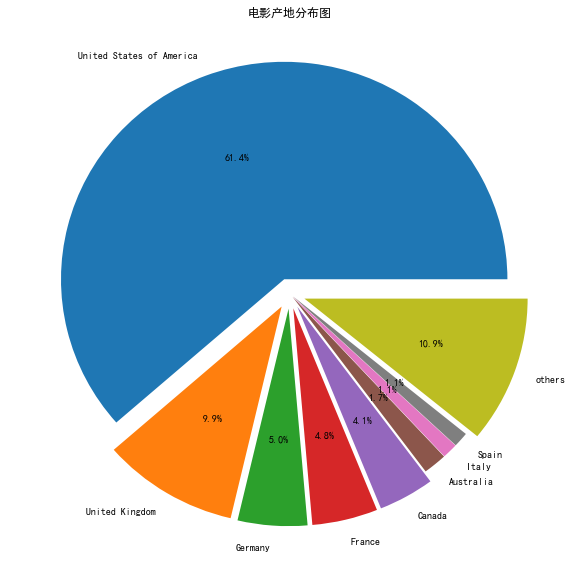

In [38]:
country_df = get_country_count(total)
show_country_count(country_df)

### 3-5-电影关键字

In [39]:
def get_and_show_keywords(total):
    keywords_list = []
    for item in total['keywords']:
        keywords_list.append(item)
    keywords_list = '|'.join(keywords_list)
    wc = wordcloud.WordCloud(background_color='black', max_words=3000, scale=1.5).generate(keywords_list)
    plt.figure(figsize=(14, 8))
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

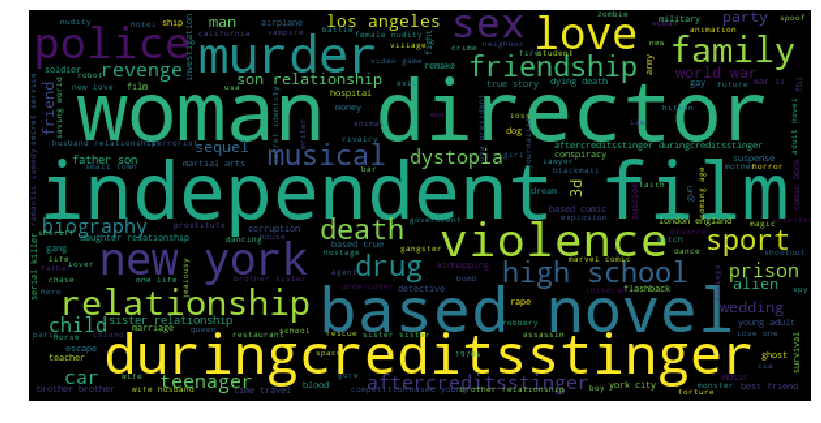

In [40]:
get_and_show_keywords(total)

### 3-6-受众喜好与那些因素有关

电影类型与受众欢迎度

In [43]:
def get_popular_genre(total):
    popular_genre_df = pd.DataFrame()
    popular_genre_df = pd.concat([genre_df.iloc[:, :-1], total['popularity']], axis=1)
    popular_list = []
    for genre in genre_set:
        popular_list.append(popular_genre_df.groupby(genre)['popularity'].mean().loc[1])
    popular_genre = pd.DataFrame(index=genre_set)
    popular_genre['popularity'] = popular_list
    print(popular_genre)
    return popular_genre

In [44]:
def show_popular_genre(popular_genre):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    popular_genre.sort_values(by='popularity').plot.barh(label='genre')
    plt.title('电影类型受欢迎分布')
    plt.xlabel('受欢迎程度')
    plt.ylabel('电影类型')
    plt.show()

                 popularity
War               23.777289
Mystery           24.586827
Foreign            0.686787
Drama             17.764853
Documentary        3.945724
Crime             22.853274
Comedy            18.221001
Science Fiction   36.451806
TV Movie           6.389415
Animation         38.813439
Music             13.101512
Horror            18.295915
Western           18.236279
Family            27.832849
History           17.444839
Adventure         39.268042
Romance           15.962426
Action            30.940382
Fantasy           36.387043
Thriller          24.460077


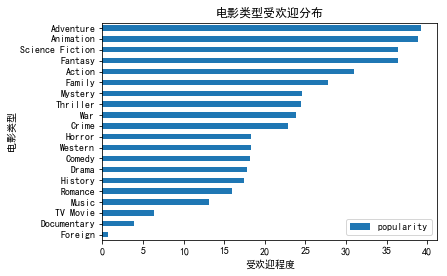

In [45]:
popular_genre = get_popular_genre(total)
show_popular_genre(popular_genre)

由图可见，最受观众欢迎的电影类型是冒险类（Adventure）和动画类（Animation），其次为科幻类。

电影时长与受众欢迎度

In [47]:
def get_and_show_popular_runtime(total):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.scatter(total['runtime'], total['popularity'])
    plt.title('电影时长和欢迎度的分布')
    plt.xlabel('电影时长')
    plt.ylabel('受欢迎程度')
    plt.show()

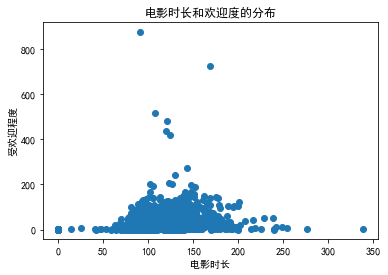

In [48]:
get_and_show_popular_runtime(total)

受众欢迎度较高的电影的时长基本在90-150分钟之间。

电影评分与受众欢迎度

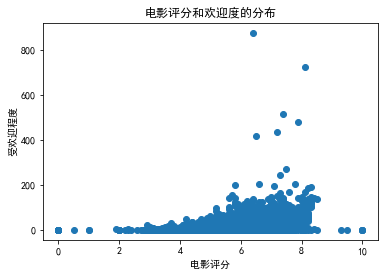

In [50]:

def get_and_show_popular_vote(total):
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.scatter(total['vote_average'], total['popularity'])
    plt.title('电影评分和欢迎度的分布')
    plt.xlabel('电影评分')
    plt.ylabel('受欢迎程度')
    plt.show()
get_and_show_popular_vote(total)

电影评分与受欢迎度之间的相关性不太明显，评分高的电影，受众欢迎度却不一定高，比如冷门好片的存在？但受众欢迎度高的，电影评分基本也不低，群众的眼睛是雪亮的，制作公司产出好片，获得受众喜爱的概率也更高。经过更多受众的检验，该电影为好片的可靠性也更高。

### 3-7-Universal Pictures与Paramount Pictures两家巨头公司的业绩如何

In [58]:
def get_company_data(total):
    company_list = ['Universal Pictures', 'Paramount Pictures']
    company_df = pd.DataFrame()
    for company in company_list:
        company_df[company] = total['production_companies'].str.contains(company).map(lambda x: 1 if x else 0)
    company_df = pd.concat([company_df, genre_df.iloc[:, :-1], total['profit']], axis=1)
    return company_list, company_df

In [59]:
def get_company_genre(total):
    company_list, company_df = get_company_data(total)
    # 当设置了索引是哪些的时候，设置数据时就会对应填入
    company_genre = pd.DataFrame(index=genre_set)
    for company in company_list:
        company_genre[company] = company_df.groupby(company).sum().loc[1]
        company_genre[company]
    return company_genre

In [60]:
def show_company_genre(company_genre):
    plt.style.use('ggplot')
    fig = plt.figure(figsize=(16,8))
    ax1 = fig.add_subplot(1,2,1)
    plt.pie(company_genre['Universal Pictures'],labels=company_genre.index,autopct='%.1f%%')
    plt.title('Universal Pictures')

    ax2 = fig.add_subplot(1,2,2)
    plt.pie(company_genre['Paramount Pictures'],labels=company_genre.index,autopct='%.1f%%')
    plt.title('Paramount Pictures')

    plt.show()

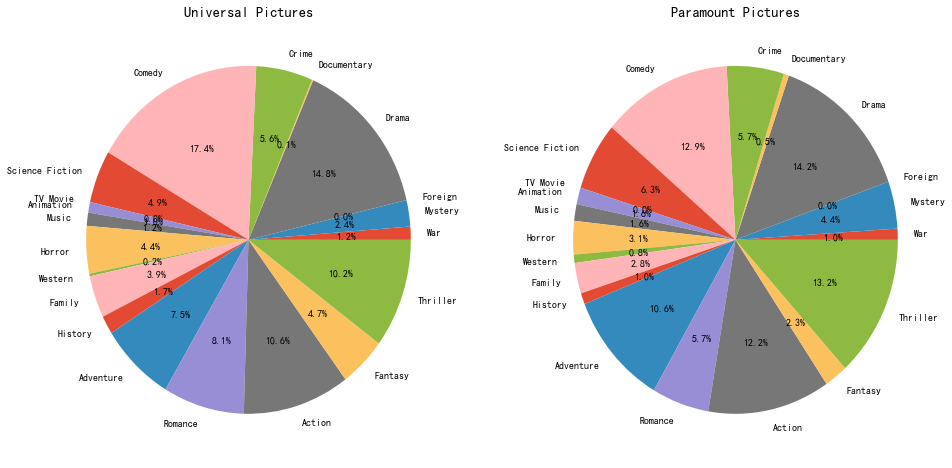

In [61]:
company_genre = get_company_genre(total)
show_company_genre(company_genre)

### 3-8-电影票房与哪些因素最相关

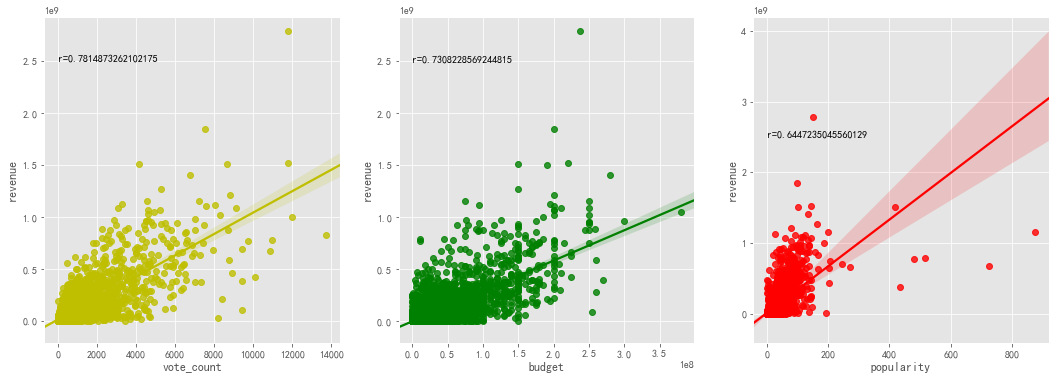

In [63]:
import seaborn as sns
def get_and_show_correlation(total):
    '''
    计算相关系数
    :param total:
    :return:
    '''
    cols = ['budget','popularity','release_date','runtime','vote_average','vote_count','revenue']
    corrs = total[cols].corr()
    # get the  correlation coefficents between revenue and others
    revenue = corrs['revenue']
    revenue = revenue.drop(['revenue']).sort_values(ascending=False)
    # get the factors strong correlative with factor revenue
    revenue = revenue[revenue > 0.5]
    fig = plt.figure(figsize=(18,6))
    colors = ['y','g','r']
    i = 1
    for factor in revenue.index:
        ax = plt.subplot(1,3,i)
        ax = sns.regplot(x=factor,y='revenue',data=total[cols],color=colors[i-1])
        ax.text(0,2.5e9,s='r='+str(revenue[factor]))
        i += 1
    plt.show()
get_and_show_correlation(total)